In [1]:
# default_exp analyses

# Serial Position Effect
The serial position effect describes how our memory is affected by the position of information in a sequence. 
It suggests that we best remember the first and last items in a series and find it hard to remember the middle items. 
To measure the serial position effect, we find across a sample for each study -- serial -- position in a list the rate at which the item is ultimately recalled in the list. 
Then we plot this rate across positions.

## Data Preparation
For our demonstrations, we'll lean on the MurdockOkada1970 dataset. 
As a reminder, in this dataset each of 72 undergraduates was given 20 test lists with 20-word lists visually presented at either 60 or 120 words/min.

In [2]:
from compmemlearn.datasets import prepare_murdock1970_data

trials, events, list_length = prepare_murdock1970_data('../../data/mo1970.txt')
events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,0,1,NaN,True,False,0,False
1,1,1,1,2,NaN,True,False,0,False
2,1,1,2,3,NaN,True,False,0,False
3,1,1,3,4,NaN,True,False,0,False
4,1,1,4,5,NaN,True,False,0,False


## Analysis

### DataFrame
We can usually rely on the `psifr` library to generate `pandas` DataFrames containing serial position curve information. 

In [3]:
from psifr import fr

spc = fr.spc(events)
spc 

recall
subject input        
1       1        0.40
        2        0.10
        3        0.25
        4        0.30
        5        0.10
...               ...
72      16       0.20
        17       0.80
        18       0.85
        19       0.95
        20       1.00

[1440 rows x 1 columns]

### Fast Array Generation
`DataFrame`s contain granular subject-by-subject information and are easier to plot using the `seaborn` library. 
But sometimes we don't need this granular information and mainly want to perform our analysis as quickly as possible -- perhaps to help with model fitting or analysis. 
In that case, representing results with `numpy` arrays and performing just-in-time compilation of our function using `numba` might be preferred. 
We include `analyses.fast_spc` in our library for that purpose here.

In [4]:
# export

from numba import njit
import numpy as np

@njit(nogil=True)
def fast_spc(trials, item_count):
    return np.bincount(trials.flatten(), minlength=item_count+1)[1:]/len(trials)

In [5]:
fast_spc(trials, 20)

array([0.44305556, 0.29097222, 0.22222222, 0.18958333, 0.13888889,
       0.15694444, 0.15486111, 0.14097222, 0.16041667, 0.18958333,
       0.15347222, 0.1875    , 0.21875   , 0.25347222, 0.27847222,
       0.3125    , 0.39722222, 0.5875    , 0.68819444, 0.7875    ])

We can compare the runtimes of `compmemlearn`'s `analyses.fast_spc` and `psifr`'s `fr.spc` using the `%%timeit` Jupyter magic:

In [6]:
%%timeit
fast_spc(trials, 20)

34.1 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit
fr.spc(events)

5.97 ms ± 438 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
fr.spc(events)

recall
subject input        
1       1        0.40
        2        0.10
        3        0.25
        4        0.30
        5        0.10
...               ...
72      16       0.20
        17       0.80
        18       0.85
        19       0.95
        20       1.00

[1440 rows x 1 columns]

Our fast implementation is more than 100 times faster!

## Plotting
`psifr`'s plotting library creates a separate figure for each plot, when sometimes we want to to include multiple plots in one figure, so we define our own.

In [9]:
# # export

# import seaborn as sns
# import matplotlib.pyplot as plt
# from psifr import fr
# from compmemlearn.fitting import apply_and_concatenate
# from compmemlearn.datasets import events_metadata, generate_trial_mask

# def plot_spc(data, trial_query, axis=None, contrast_name=None, labels=None):

#     trials, list_lengths = events_metadata(data)[:2]
#     trial_mask = generate_trial_mask(events, trial_query)

#     trials = [t for t in trials if len(t) > 0]
#     presentations = [p for p in presentations if len(p) > 0]
#     list_lengths = [list_lengths[i] for i in range(len(list_lengths)) if len(trials[i]) > 0]

#     if axis is None:
#         plt.figure()
#         axis = plt.gca()

#     if isinstance(data, list):
#         assert(len(labels) == len(data))
#         assert(contrast_name is not None)
#         data = apply_and_concatenate(fr.spc, data, contrast_name, labels)
#     else:
#         data = fr.spc(data)

#     sns.lineplot(ax=axis, data=data, x='input', y='recall', err_style='bars', hue=contrast_name)
#     axis.set(xlabel='Study Position', ylabel='Recall Rate')
#     axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
#     axis.set_ylim((0, 1))

#     if labels is not None:
#         axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#     return axis

In [10]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask


def plot_spc(data, trial_query, contrast_name='', labels=None, axis=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        trial_mask = trial_mask[chose]

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            spc = fast_spc(trials[subject_specific_trial_mask], list_length)
            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "input": np.arange(1, list_length + 1),
                    "recall": spc,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result)

    sns.lineplot(ax=axis, data=result, x='input', y='recall', err_style='bars', hue=contrast_name)
    axis.set(xlabel='Study Position', ylabel='Recall Rate')
    axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
    axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis

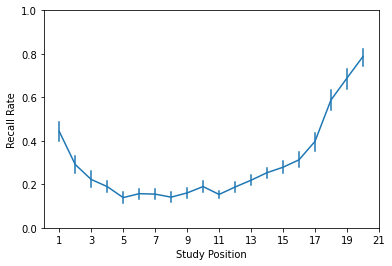

In [11]:
import matplotlib.pyplot as plt

plt.figure()
axis = plt.gca()
plot_spc([events], 'subject > -1', axis=axis);